In [6]:
import sys
sys.path.append('H:/毕业论文/pykan')
sys.path.append('H:/毕业论文/efficient-kan/src')
sys.path.append('H:/毕业论文/fast-kan/fastkan')

from efficient_kan import KAN as EKAN
from fastkan import FastKAN as FKAN
import torch
torch.set_default_dtype(torch.float64)
import torch.nn as nn
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from kan import KAN, LBFGS
import numpy as np
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 添加一些空白行以提高可读性

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)


Using device: cuda:0


In [7]:
#geom 物理区域
L = 800  ##SiCsub strate thickness(the solutionregion depth)
h = 150  ##metal film thickness 1nm = 1e-7cm
geom = [0,L]
num_points_x = 128  #网格的大小

#时间区域  For time-independent PDE, we don't need this.
time_length = 60   #minutes  
TimeDomain = [0,time_length]
num_points_t = 50


# geomtime = dde.geometry.GeometryXTime(dde.geometry.Interval(geom[0],geom[1]),dde.geometry.TimeDomain(TimeDomain[0],TimeDomain[1]))

def generate_data(num_domain,num_init,num_bound):
    ##域内点 points in domain  
    x_domain = torch.rand(num_domain, 1) * L   # 生成均匀分布在 [0, L] 内的 x
    t_domain = torch.rand(num_domain, 1) * time_length   # 生成均匀分布在 [0, T] 内的 t
    points_domain = torch.cat((x_domain, t_domain), dim=1)
    # print(points_domain,points_domain.shape)

    ##初始点 points in initial 
    x_init = torch.rand(num_init, 1) * L   # 生成均匀分布在 [0, L] 内的 x
    t_init = torch.zeros(num_init, 1)      # 生成size大小的全0张量  [X,0]
    points_init = torch.cat((x_init, t_init), dim=1)
    # print(points_init,points_init.shape)

    ##边界点 points on boundary
    x_bound_left = torch.zeros(num_bound, 1)   # 生成[0,T]  左边界
    x_bound_right = torch.full((num_bound, 1),L)  # 生成[L,T]  右边界
    t_bound = torch.rand(num_bound, 1) * time_length   # 生成均匀分布在 [0, T] 内的 t
    points_bound_left = torch.cat((x_bound_left, t_bound), dim=1)  # 生成[0,T]  左边界
    points_bound_right = torch.cat((x_bound_right,t_bound), dim=1)  # 生成[L,T]  右边界
    # print(points_bound_left,points_bound_left.shape)
    # print(points_bound_right,points_bound_right.shape)

    # 合并所有点
    points = torch.cat((points_domain, points_init, points_bound_left, points_bound_right), dim=0)
    # print(points,points.shape)
    return points

# generate_data(400,100,50)
#网格化
x = torch.linspace(geom[0], geom[1], 
                   steps=num_points_x, device=device,
                   requires_grad=False)

t = torch.linspace(TimeDomain[0],TimeDomain[1],
                   steps=num_points_t, device=device,
                   requires_grad=False)

X,T = torch.meshgrid(x, t, indexing='ij')
coordinates = generate_data(5000,250,125).to(device)
# coordinates = torch.stack([X.flatten(), T.flatten()], dim = 1).to(device)
# print(coordinates,coordinates.shape)
coordinates.requires_grad = True  # Ensure coordinates require grad 确保coordinates需要梯度
##
##这一步的目的是生成一个二维网格，将空间和时间域内的离散点组合成所有可能的坐标对，
##从而用于进一步的计算或模型训练。这种方法常用于物理学、工程学和机器学习中的数值模拟和求解偏微分方程（PDEs）

In [8]:
#注意到我们其实需要的是一个 两个输入x和t 一个输出真解u 的KAN神经网络
layer = [2] + [8]*2 + [6]   #[input] + [nn]*hiden + [output] 

# #oringinal KAN
# model = KAN(width=layer, grid=3, k=3, grid_eps=1,
#             noise_scale_base=0.25,device = device)

#efficient - KAN
# model = EKAN(layer,grid_size=3,spline_order=3,scale_noise=0.25,grid_eps=1.0,base_activation=nn.Identity).to(device)
model = FKAN(layer,grid_size=6).to(device)

In [9]:
D_A = 6  #6nm^2/s
kf_11 = 0
kf_21 = 0
kf_12 = 0

N_SA = 90  
N_SB = 48  #nm^{-3}

def pde(coords):
    #前置定义过程
    coords = coords.clone().detach().requires_grad_(True)  # Ensure coords require grad
    grads = batch_jacobian(model , coords, create_graph= True)  #计算Jacobian矩阵 batch_jacobian(fun, variable, creat_graph = True)
    hessians = batch_hessian(model, coords)

    #PDE的定义过程： 
    c_a = model(coords)[:,0]  #predicted solution
    c_bc = model(coords)[:,1]  #predicted solution
    c_c = model(coords)[:,2]  #predicted solution
    c_ab = model(coords)[:,3]  #predicted solution
    c_abb = model(coords)[:,4]  #predicted solution
    c_aab = model(coords)[:,5]  #predicted solution

    #微分项
    dca_dx = grads[:,0,0]  #d_ca/dx
    dcbc_dx = grads[:,1,0]  #d_cbc/dx
    dcc_dx = grads[:,2,0]  #d_cc/dx
    dcab_dx = grads[:,3,0]  #d_cab/dx
    dcabb_dx = grads[:,4,0]  #d_cabb/dx
    dcaab_dx = grads[:,5,0]  #d_caab/dx

    #公共求和项目
    C_sigma_bottom = c_a + c_bc + c_c + c_ab +c_abb + c_aab
    C_sigma_up = c_bc + c_c + c_ab +c_abb + c_aab
    dsigma_dx = dcbc_dx + dcc_dx + dcab_dx + dcabb_dx + dcaab_dx
    D_star = D_A * (C_sigma_up / C_sigma_bottom)

    ##Eq 4:
    dca_dt = grads[:,0,1]  #d_ca/dt
    dca_dxx = hessians[:,0, 0]  #d^2_ca/dx^2
    eq_1 = dca_dt - D_star * dca_dxx - D_A * ((c_a * dsigma_dx - C_sigma_up * dca_dx )/ (C_sigma_bottom)**2) * dca_dx + \
           kf_11 * c_a * c_bc + kf_21 * c_a * c_ab 
    
    ##Eq 5:
    dcbc_dt = grads[:,1,1]  #d_cbc/dt
    dcbc_dxx = hessians[:,1,0]  #d^2_cbc/dx^2
    eq_2 = dcbc_dt - D_star * dcbc_dxx - D_A * ((c_a * dsigma_dx - C_sigma_up * dca_dx )/ (C_sigma_bottom)**2) * dcbc_dx + \
           kf_11 * c_a * c_bc + kf_12 * c_ab * c_bc

    ##Eq 6:
    dcc_dt = grads[:,2,1]  #d_cc/dt
    dcc_dxx = hessians[:,2,0]  #d^2_cc/dx^2
    eq_3 = dcc_dt - D_star * dcc_dxx - D_A * ((c_a * dsigma_dx - C_sigma_up * dca_dx )/ (C_sigma_bottom)**2) * dcc_dx - \
           kf_11 * c_a * c_bc - kf_12 * c_ab * c_bc
    
    ##Eq 7:
    dcab_dt = grads[:,3,1]  #d_cab/dt
    eq_4 = dcab_dt - kf_11 * c_a * c_bc + kf_21 * c_a * c_ab 

    ##Eq 8:
    dcabb_dt = grads[:,4,1]  #d_cabb/dt
    eq_5 = dcabb_dt - kf_12 * c_ab * c_bc

    ##Eq 9:
    dcaab_dt = grads[:,5,1]  #d_caab/dt
    eq_6 = dcaab_dt - kf_21 * c_a * c_ab

    loss_pde = torch.mean(eq_1 ** 2) + torch.mean(eq_2 ** 2) + torch.mean(eq_3 ** 2) + \
               torch.mean(eq_4 ** 2) + torch.mean(eq_5 ** 2) + torch.mean(eq_6 ** 2)

    ###########################################PDE 部分定义结束 ##############################################################
    ##边界条件 BC  Neumann-BC
    BC_mask_left = (coords[:, 0] == geom[0]) 
    BC_mask_righ = (coords[:, 0] == geom[1])

    ca_BC_left = batch_jacobian(model, coords[BC_mask_left],create_graph= True)[:,0]
    cbc_BC_left = batch_jacobian(model, coords[BC_mask_left],create_graph= True)[:,1]
    cc_BC_left = batch_jacobian(model, coords[BC_mask_left],create_graph= True)[:,2]

    ca_BC_righ = batch_jacobian(model, coords[BC_mask_righ],create_graph= True)[:,0]
    cbc_BC_righ = batch_jacobian(model, coords[BC_mask_righ],create_graph= True)[:,1]
    cc_BC_righ = batch_jacobian(model, coords[BC_mask_righ],create_graph= True)[:,2]
    loss_bc = torch.mean(ca_BC_left**2) + torch.mean(cbc_BC_left**2) + torch.mean(cc_BC_left**2) + \
              torch.mean(ca_BC_righ**2) + torch.mean(cbc_BC_righ**2) + torch.mean(cc_BC_righ**2)
    
    ##初始条件 IC
    IC_mask = (coords[:, 1] == TimeDomain[0])
    IC_points = coords[IC_mask]

    selected_h = IC_points[IC_points[:,0]<=h]
    selected_L = IC_points[(IC_points[:,0]>=h) & (IC_points[:,0]<=L)]

    IC_ca_in = model(selected_h)[:,0]
    IC_ca_out = model(selected_L)[:,0]
    IC_cbc_in = model(selected_L)[:,1]
    IC_cbc_out = model(selected_h)[:,1]

    IC_cc = model(IC_points)[:,2]
    IC_ab = model(IC_points)[:,3]
    IC_abb = model(IC_points)[:,4]
    IC_aab = model(IC_points)[:,5]

    loss_ic = torch.mean((IC_ca_in - N_SA)**2) + torch.mean((IC_cbc_in -N_SB) **2) + torch.mean(IC_cc**2) + \
              torch.mean(IC_ab**2) + torch.mean(IC_abb**2) + torch.mean(IC_aab**2) + \
              torch.mean(IC_ca_out**2) + torch.mean(IC_cbc_out**2)

    total_loss = loss_pde + loss_ic + loss_bc

    return total_loss


In [10]:
Loss = []
l2_losses = []
writer = SummaryWriter()

def train():
    # optimizer = LBFGS(model.parameters(), lr=1,
    #                   history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    # optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
    optimizer = optim.LBFGS(model.parameters(),
                        lr=1e-1,
                        max_iter=20,
                        max_eval=None,
                        tolerance_grad=1e-5,
                        tolerance_change=1e-9,
                        history_size=10,
                        line_search_fn="strong_wolfe")    
    
    steps = 100# 20 steps are enough
    pbar = tqdm(range(steps), desc='Training Progress')
    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = pde(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 2 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.6f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)
        Loss.append(closure().item())
        # l2_losses.append(l2.detach().numpy())
        # print("Current Loss: ",Loss[step])

train()
writer.close()
print(Loss)
plt.plot(Loss, marker='o')
plt.plot(l2_losses, marker='o')
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['Total loss'])
plt.title('Loss of KAN') 

Step: 62 | Loss: 2913.316955:  63%|██████▎   | 63/100 [19:14<12:10, 19.75s/it]

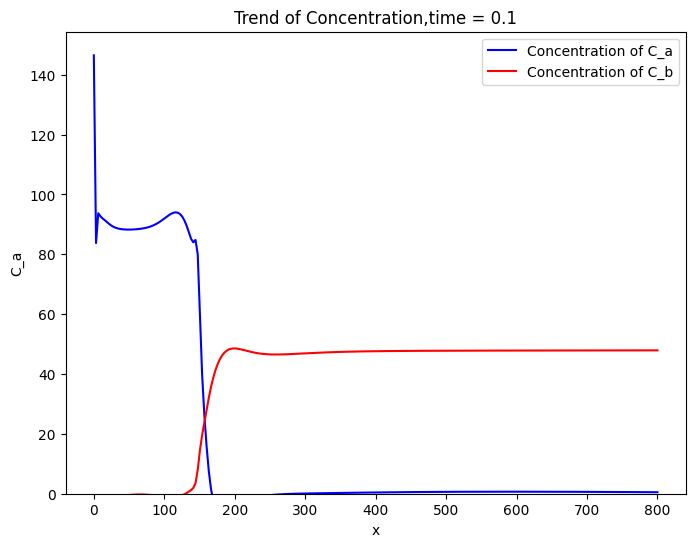

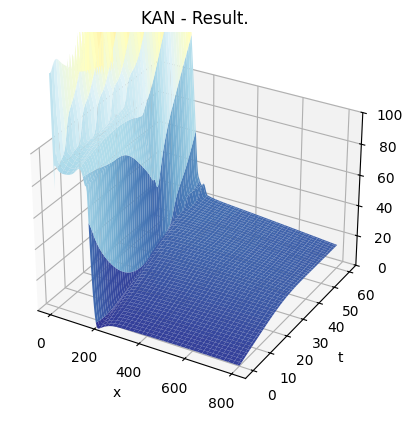

In [ ]:
#画图
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import matplotlib.pyplot as plt
x = np.linspace(0, L, 256)
t = np.linspace(0, time_length, 100)
ms_x, ms_t = np.meshgrid(x, t)
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)
pt_x = torch.from_numpy(x).double().requires_grad_(True).to(device)
pt_t = torch.from_numpy(t).double().requires_grad_(True).to(device)

result = model(torch.cat([pt_x,pt_t],1)).data.cpu().numpy()
c_a = result[:,0]
c_b = result[:,1]

c_a=c_a.reshape(100,256)
c_b=c_b.reshape(100,256)

component_x = np.linspace(0, L, 256)

plt.figure(figsize=(8, 6))
plt.plot(component_x, c_a[1], label=r'Concentration of C_a', color='b')
plt.plot(component_x, c_b[1], label=r'Concentration of C_b', color='r')
plt.title('Trend of Concentration,time = 0.1')
plt.xlabel('x')
plt.ylabel('C_a')
plt.ylim(bottom=0)
plt.legend()
# plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlim([0, 100])
ax.plot_surface(ms_x, ms_t, c_a, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('KAN - Result.') 
plt.show(fig)